In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

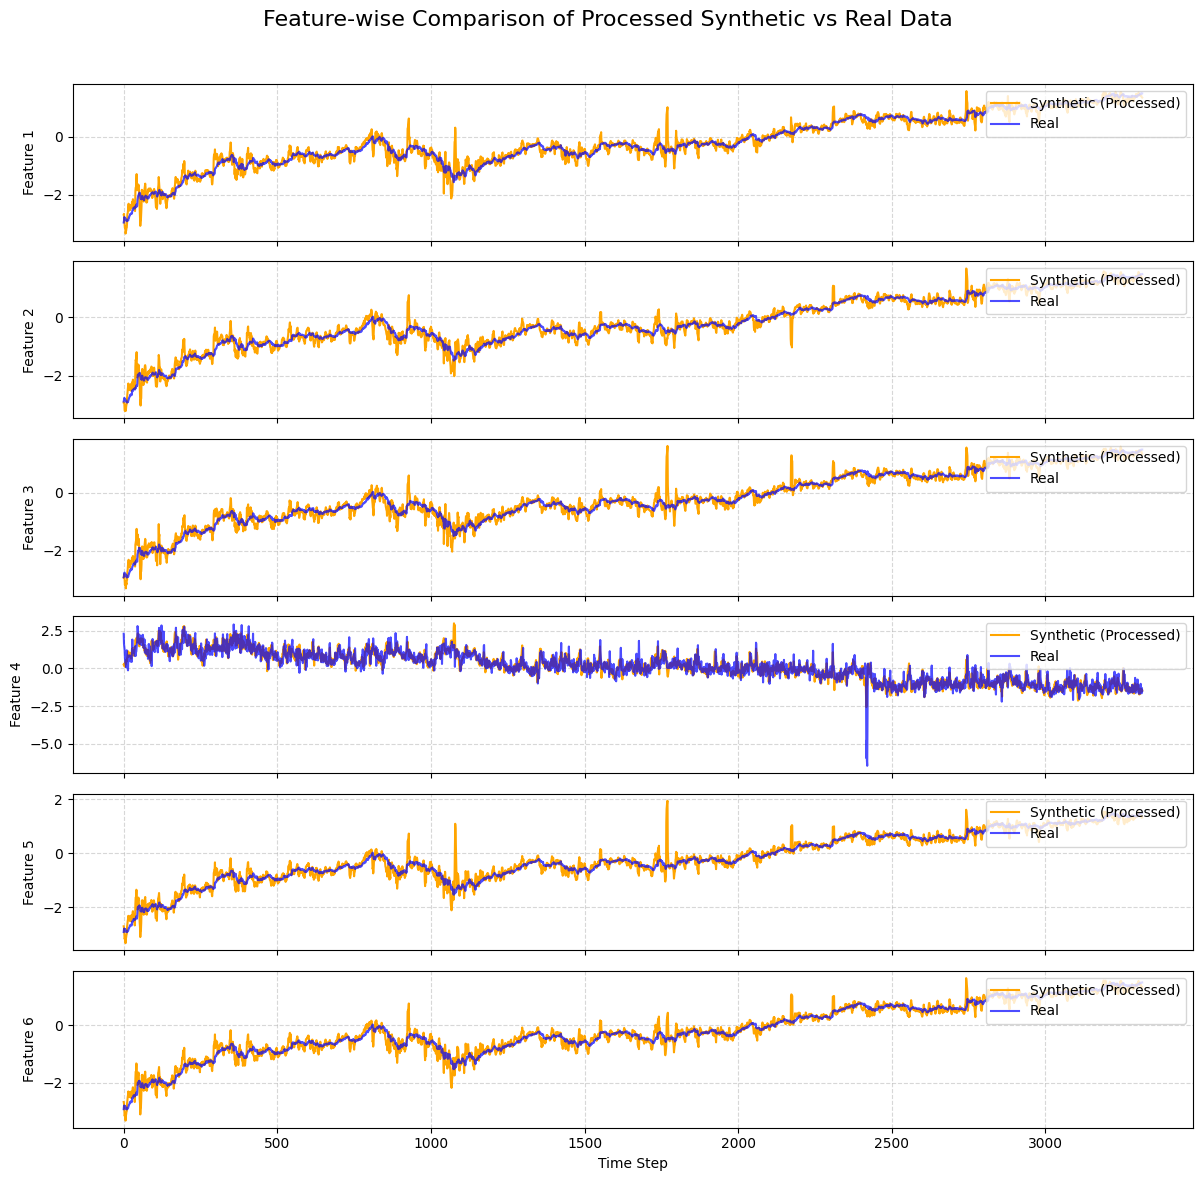

In [ ]:
# ==== Load the denorm_smoothed_rescaled data ====
processed_syn = np.load("")
real_data = np.load("")[0][:processed_syn.shape[0]]

n_features = processed_syn.shape[1]

# ==== Plot ====
fig, axes = plt.subplots(n_features, 1, figsize=(12, 2*n_features), sharex=True)

for i in range(n_features):
    axes[i].plot(processed_syn[:, i], label='Synthetic (Processed)', color='orange')
    axes[i].plot(real_data[:, i], label='Real', color='blue', alpha=0.7)
    axes[i].set_ylabel(f'Feature {i+1}')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Time Step')
fig.suptitle('Feature-wise Comparison of Processed Synthetic vs Real Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# ==============================================================================
# 0. Define Variables
# ==============================================================================
window_size = 24  # This should match the window size used for training the model

# ==============================================================================
# 1. Read and Load Both Files
# ==============================================================================
print("Step 1: Loading data...")
try:
    real_ts = real_data
    synthetic_ts = processed_syn
except FileNotFoundError as e:
    print(f"Error: {e}.")
    exit()

print(f"  - Loaded real data with shape: {real_ts.shape}")
print(f"  - Loaded synthetic data with shape: {synthetic_ts.shape}")
assert real_ts.shape == synthetic_ts.shape, "Real and synthetic time series must have the same shape."

# ==============================================================================
# 2. Create Sliding Windows
# ==============================================================================
print("\nStep 2: Creating sliding windows...")

def create_sliding_windows(data, window_size):
    """
    Creates a dataset of overlapping sliding windows from a single time series.

    Args:
        data (np.ndarray): The input time series of shape (total_length, num_features).
        window_size (int): The length of each window.

    Returns:
        np.ndarray: A new dataset of shape (num_windows, window_size, num_features).
    """
    total_length = data.shape[0]
    num_features = data.shape[1]

    num_windows = total_length - window_size + 1

    # Pre-allocate memory for efficiency
    windows = np.zeros((num_windows, window_size, num_features))

    for i in range(num_windows):
        windows[i] = data[i : i + window_size]

    return windows

real_windows = create_sliding_windows(real_ts, window_size)
synthetic_windows = create_sliding_windows(synthetic_ts, window_size)

print(f"  - Created {real_windows.shape[0]} real windows of shape {real_windows.shape[1:]}")
print(f"  - Created {synthetic_windows.shape[0]} synthetic windows of shape {synthetic_windows.shape[1:]}")

# Convert numpy arrays to PyTorch tensors for the next step
real_windows_torch = torch.from_numpy(real_windows).float()
synthetic_windows_torch = torch.from_numpy(synthetic_windows).float()

# ==============================================================================
# 3. Calculate Averaged Correlation Matrices
# ==============================================================================
print("\nStep 3: Calculating averaged cross-correlation matrices...")

def get_averaged_cross_correlation(windows_tensor, max_lag=1):
    """
    Calculates the average cross-correlation matrix across all windows.
    This function is a faithful reimplementation of the paper's `cacf_torch` logic.

    Args:
        windows_tensor (torch.Tensor): Tensor of shape (num_windows, window_size, num_features).
        max_lag (int): The maximum lag to compute. The paper uses lag 0, so max_lag=1.

    Returns:
        torch.Tensor: The averaged cross-correlation matrix of shape (num_feature_pairs,).
    """
    # Get all unique pairs of features, including self-pairs (i, i)
    num_features = windows_tensor.shape[2]
    # tril_indices gives lower-triangular indices, which is what we need for pairs
    feature_pairs_indices = torch.tril_indices(num_features, num_features)

    # Standardize each feature channel across all windows and time steps
    # This is crucial for calculating correlation. dim=(0, 1) means standardize over
    # the num_windows and window_size dimensions.
    x = windows_tensor
    x = (x - x.mean(dim=(0, 1), keepdims=True)) / x.std(dim=(0, 1), keepdims=True)

    # Get the time series data for the left and right side of each pair
    # x_l and x_r will have shape (num_windows, window_size, num_feature_pairs)
    x_l = x[..., feature_pairs_indices[0]]
    x_r = x[..., feature_pairs_indices[1]]

    cacf_list = []
    # Loop for each lag. For the paper's metric, only lag 0 is needed (range(1)).
    for i in range(max_lag):
        if i == 0:
            # For lag 0, correlate x_l(t) with x_r(t)
            y = x_l * x_r
        else:
            # For lag i, correlate x_l(t) with x_r(t-i)
            # We slice to align the time series correctly
            y = x_l[:, i:] * x_r[:, :-i]

        # Average over the time dimension (dim=1) to get the correlation for each window
        cacf_i = torch.mean(y, dim=1)
        cacf_list.append(cacf_i)

    # Concatenate results from all lags
    cacf = torch.cat(cacf_list, dim=1)

    # Finally, average the correlations across all windows (dim=0)
    avg_cacf = cacf.mean(dim=0)

    return avg_cacf

# Calculate the ground-truth matrix from real data
real_avg_corr_matrix = get_averaged_cross_correlation(real_windows_torch, max_lag=1)

# Calculate the matrix from the generated data
synthetic_avg_corr_matrix = get_averaged_cross_correlation(synthetic_windows_torch, max_lag=1)

print(f"  - Calculated average correlation matrices of shape: {real_avg_corr_matrix.shape}")


# ==============================================================================
# 4. Calculate Final Metric and Print
# ==============================================================================
print("\nStep 4: Calculating the final difference metric...")

# Subtract the two averaged matrices
difference = synthetic_avg_corr_matrix - real_avg_corr_matrix

# Calculate the sum of the absolute values of the differences
# This is the "xCorr" metric
xcorr_metric = torch.abs(difference).sum() / 10

print("\n" + "="*50)
print(f"Final Cross-Correlation Difference (xCorr): {xcorr_metric.item():.4f}")
print("="*50)
print("\nThis value represents the sum of absolute differences between the average")
print("lag-0 cross-correlation matrix of the real data and the synthetic data.")

Step 1: Loading data...
  - Loaded real data with shape: (3316, 6)
  - Loaded synthetic data with shape: (3316, 6)

Step 2: Creating sliding windows...
  - Created 3293 real windows of shape (24, 6)
  - Created 3293 synthetic windows of shape (24, 6)

Step 3: Calculating averaged cross-correlation matrices...
  - Calculated average correlation matrices of shape: torch.Size([21])

Step 4: Calculating the final difference metric...

Final Cross-Correlation Difference (xCorr): 0.010

This value represents the sum of absolute differences between the average
lag-0 cross-correlation matrix of the real data and the synthetic data.
